In [306]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import numpy as np
import sympy as sy
from sympy import symbols
from scipy import interpolate
from scipy import optimize
import matplotlib
from matplotlib import pyplot as plt

In [307]:
##PARAMETRI INIZIALI

pars = camb.CAMBparams()  #0.022 0.122 67.5
pars.set_cosmology(H0=73, ombh2=0.023, omch2=0.111)   #H0= hubble parameter today in km/s    ombh2=physical density in baryons omch2=physical density in cold dark matter
#trovo densità diverse...
pars.InitPower.set_params(ns=0.965)  #ns = scalar spectra index (inflaction)


class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.965
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2e-09
 At = 1.0
 

In [308]:
def dist(z):   #funzione per trasformare il redshift in distanza
    return (3e5/70)*z #coefficiente per trasformare il redshift in un raggio, c/H0 = [km/s  / (km/s)/Mpc] = [Mpc], z è adimensionale


In [309]:
pars.set_matter_power(redshifts=[0.17], kmax=3.0)  
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)   

In [310]:
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-2, maxkh=1e-1, npoints = 100) #nota, le z vengono ordinate, ricavo spettro di potenza

In [311]:
H0 = results.hubble_parameter(0)    #parametri di hubble
h = H0/100
def H(z):
    return results.hubble_parameter(z)

kh = kh/h  #H0 = 70km/(s*Mpc) h=0.7 ma non era senza unità di misura?
pk = pk*h**3

In [312]:
bias = 1 + z[0]*0.84   #funzione di bias delle galassie, cercane altre!!
f = (results.get_fsigma8()/results.get_sigma8())
 #la calcola alla z scelta già, UNITà DI MISURA

mu = np.arange(-1,1,0.1)      #range di valori dell'angolo
N = len(kh)*len(mu)   #numero di dati simulati

In [313]:
#Set di dati simulati spettro di potenza delle galassie

Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        Pgg[i][j] = ( float(np.power(bias + f * np.power(mu[j],2),2)*pk[:,i]))


In [314]:
#Dati per la funzione teorica
#om=(0.134)/(h**2)  #PRESO DA QUELLE INIZIALI MA NON TORNANO COI DATI, ho usato una h diversa
#omb= 0.31  # densità di materia per z=0, presa da libro
om = results.get_Omega('cdm',0) + results.get_Omega('baryon',0)    #densità di materia nell'universo
omz= om*(1+z[0])**3/(H(z[0])/H0)**2 #densità di materia a diverso z
omz

0.3495742077382213

In [315]:
#get_Omega(var, z=0)
#h_of_z(z)

In [316]:
print(f)
print(omz**0.545)

[0.56138521]
0.5639348880569439


In [317]:
##Errori dei dati simulati
ng= 15e-4   #mean galaxy number density for z near 0 (Euclid spettroscopy survey)
DeltaMu = np.abs(mu[0]-mu[1])
DeltaZ = 0.1
DeltaK = np.empty((len(kh)))

for i in range (len (kh)):
    if i==0 : DeltaK[i]= np.abs(kh[i+1]-kh[i])
    elif i==len(kh)-1:
       DeltaK[i]= np.abs(kh[i-1]-kh[i])
    else: DeltaK[i]= np.abs(kh[i+1]-kh[i])/2+ np.abs(kh[i-1]-kh[i])/2
    if(DeltaK[i]<1e-2): DeltaK[i]=1e-2   #l'intervallo deve comunque essere più grande di kmin, se non lo è lo metto uguale a kmin
    
N = np.empty((len(kh),len(mu)))
Vol = 4./3.*np.pi*((dist(z[0]+DeltaZ/2))**3-(dist(z[0]-DeltaZ/2)**3))    #calcolo il volume di cielo considerato, inmmagino di guardare il cielo su tutti gli angoli (ideale)

for j in range(len(kh)):
    N[j,:]= Vol*1/(2*np.pi)**2 * kh[j]**2*DeltaMu*DeltaK[j]  #uguale per tutte le mu

err_Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        err_Pgg[i][j] = np.sqrt(2/N[i][j])*(Pgg[i][j]+1/ng)




In [318]:
#cerco la distanza minima, per risalire il kmin da mettere all'inizio del codice

kmin= 2*np.pi/(dist(z[0]+DeltaZ/2)-dist(z[0]-DeltaZ/2))
kmin*h

0.010702358973227442

In [319]:
#faccio una trasformata di fuorier: considero il volume del guscio sferico come il volume di un cubo

Diag = np.sqrt(3) * (64)**(1/3)
2*np.pi/Diag

0.906899682117109

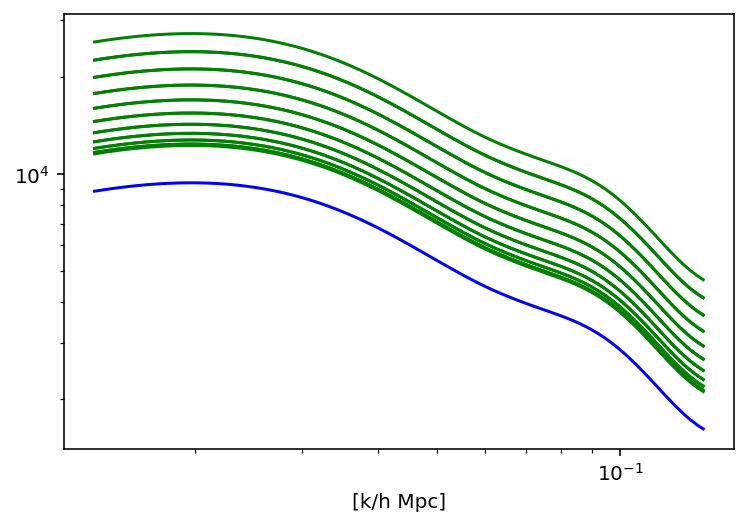

In [320]:
#Grafico

fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(kh, pk[0,:], color='b', ls = '-')
for i in range(len(mu)):
    ax.plot(kh, Pgg[:,i], color='g', ls ='-')  #aggiungi gli errori

#ax.legend(['matter','galaxy'], loc='lower left')
#plt.title('Total Matter power at z=%s and z= %s'%tuple(z));

[9963.4449293  9800.60299788 9636.89841062 9472.3747784  9307.08008683
 9141.05809325 8974.34991699 8807.00217072 8639.06708116 8470.59867893
 8301.65021127 8132.28026467 7962.55326961 7792.53710363 7622.29736971
 7451.9039573  7281.432712   7110.96449163 6940.58034739 6770.36447713
 6600.40659817 6430.80153193 6261.64747135 6093.04581949 5925.1021886
 5757.9260283  5591.63192243 5426.34039525 5262.17409815 5099.25691417
 4937.71632942 4777.69073793 4619.31905469 4462.7372304  4308.08011221
 4155.49801714 4005.14369283 3857.16078447 3711.6845203  3568.86283123
 3428.85245825 3291.79435143 3157.81305968 3027.03684004 2899.6136666
 2775.67109555 2655.31227081 2538.62718185 2425.72290056 2316.68784481
 2211.58182734 2110.44378634 2013.33621323 1920.3161343  1831.40823991
 1746.60778208 1665.86769405 1589.10451271 1516.22208113 1447.115026
 1381.70434007 1319.96996115 1261.87881311 1207.37845192 1156.34164505
 1108.47414286 1063.48089455 1021.09636408  981.07941498  943.21006575
  907.2897

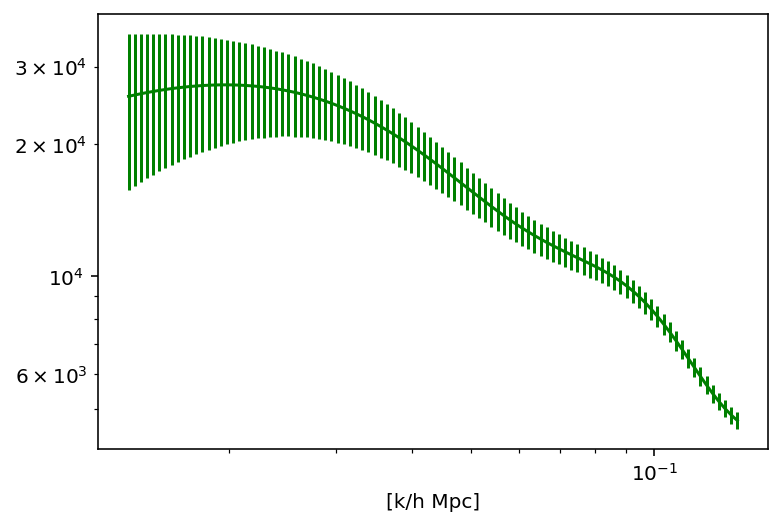

In [321]:
fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.errorbar(kh, Pgg[:,0], yerr = err_Pgg[:,0], color='g', ls ='-')  #aggiungi gli errori
print(err_Pgg[:,0])


In [322]:
gammas= np.arange(0.54,0.56,0.001)   #calcolo il chi quadro per un certo set di valori di gamma

for k in range(len(gammas)):
    gammas[k] = round (gammas[k],3)

chi2 = np.zeros(len(gammas))


for k,gamma in enumerate(gammas):
    for i in range (len(kh)):
        for j in range (len(mu)):
            chi2[k]= chi2[k]+(float((bias + (omz**gamma) * (mu[j])**2)**2*pk[:,i]) - Pgg[i][j])**2/err_Pgg[i][j]**2
        



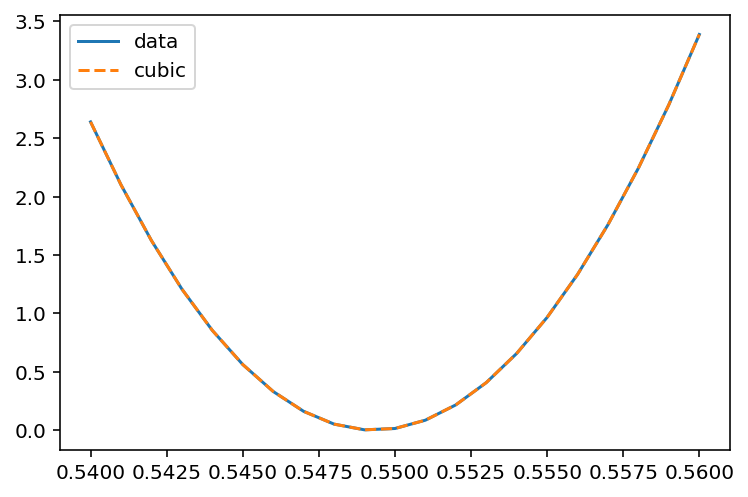

In [323]:
#INTERPOLAZIONE FUNZIONE CHI^2
interpol =  interpolate.interp1d(gammas,chi2,kind='cubic')
plt.plot(gammas,chi2,'-', gammas, interpol(gammas), '--')
plt.legend(['data', 'cubic'])


#plt.axis([0.54,0.56,0,0.4e9])

In [324]:
type(interpol)
y=lambda x: interpol(x)


In [325]:

minimo = optimize.least_squares(y,0.55)
min1= float(minimo.x)
minimo

 active_mask: array([0.])
        cost: 1.480164819725131e-15
         fun: array([5.44089114e-08])
        grad: array([4.48602878e-09])
         jac: array([[0.08245026]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 10
        njev: 10
  optimality: 4.486028775874354e-09
      status: 1
     success: True
           x: array([0.5493128])

In [326]:
chi2min= y(min1)

In [327]:
min2= np.min(chi2)      #trova un valore minimo di chi2, solo a livello discreto, meno preciso
index_min = np.argmin(chi2)
gamma_min = gammas[index_min]
gamma_min

0.549

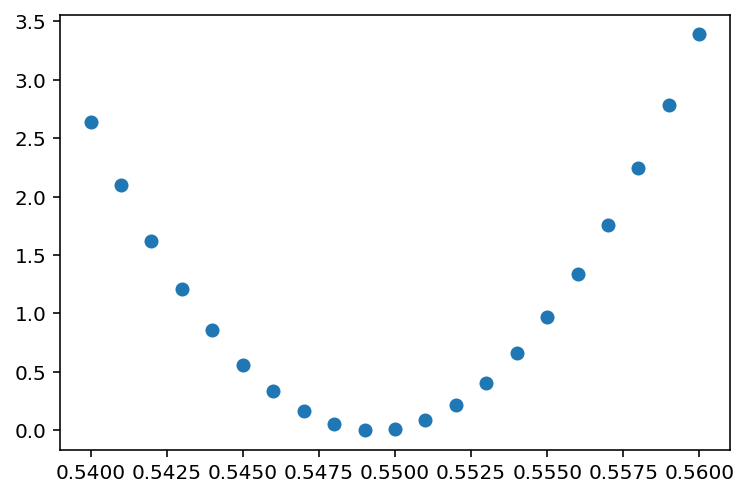

In [328]:
plt.scatter(gammas,chi2)

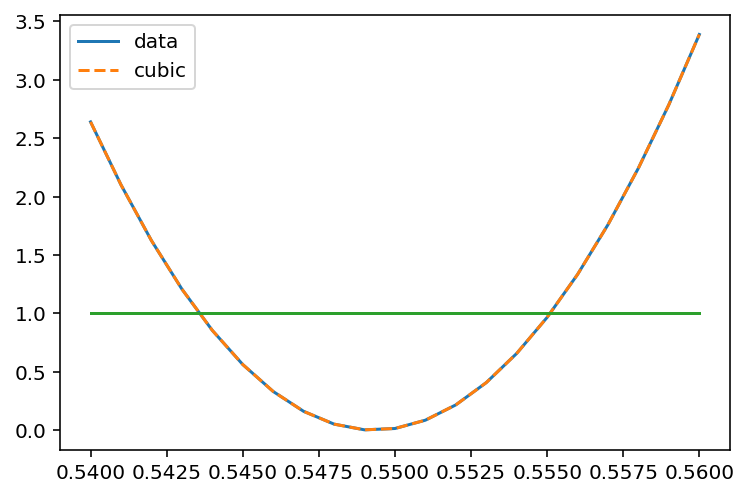

In [329]:
#devo scalare il grafico
plt.plot(gammas,chi2-chi2min,'-', gammas, interpol(gammas)-chi2min, '--')
plt.legend(['data', 'cubic'])

#CALCOLO DELL'ERRORE
xpoints= np.arange(0.54,0.56,0.001)
ypoints = np.ones(len(xpoints))
plt.plot(xpoints,ypoints)



In [334]:
y2= lambda x: interpol(x) - 1 -chi2min
error1 = optimize.brentq(y2,0.54,0.55)    #trova le soluzioni in un intervallo fissato
error2 = optimize.brentq(y2,0.55,0.56)
print(error1,error2)

0.5435669800117817 0.555099530213266


In [337]:
print(np.abs(min1-error1))
print(np.abs(min1-error2))

sigma = 0.006

0.005745817177553514
0.005786733023930735


In [341]:
print("Il valore di gamma trovat è: ", round(min1,3) ," +- ", sigma)

Il valore di gamma trovat è:  0.549  +-  0.006


In [ ]:
#facciamo il fit, posso usare optimize perché ho l'errore su una sola variabile

#def func(i, gamma):
#    return (bias + (omz**gamma) * (mu[j])**2)**2*pk[:,i]
#
#index = np.array(0,len(kh),1)
#popt, pcov = optimize.curve_fit(func, index , Pgg[:,?], err_Pgg)  #non so che fare con ste mu
